In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import kerastuner as kt
from kerastuner.engine.hyperparameters import HyperParameters
import optuna
import sklearn
from sklearn.model_selection import train_test_split
import random
import time
import os
import cv2
os.getcwd()

'D:\\Stat\\Python\\Image_process\\Project-1_Item_recogniser'

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
labels_file = open("D:/Stat/Python/Image_process/Project-1_Item_recogniser/data/labels.txt", "r")
labels = [i for i in labels_file.readlines()]
for i in labels:
    if i == labels[-1]:
        a = i[0:-1]
    a = i[0:-2]
    labels[labels.index(i)] = a

In [3]:
indexes = np.unique(np.asanyarray(labels), return_index=True)[1]
labels_cat = [labels[index] for index in sorted(indexes)]
labels_cat.pop()
labels_cat

['chocolate',
 'cookie',
 'drink',
 'bleach',
 'deodorant',
 'tooth paste',
 'olives',
 'meat',
 'milk']

In [4]:
counts = []
for i in labels_cat:
    count = len(os.listdir(f"D:/Stat/Python/Image_process/Project-1_Item_recogniser/data/photos/{i}/"))
    counts.append(count)

In [5]:
df_photos = []
n = 0
for i in range(len(labels_cat)):
    for j in range(counts[i]):
        n+=1
        df_photos.append("D:/Stat/Python/Image_process/Project-1_Item_recogniser/data/photos/{}/photo_{}.jpg".format(labels_cat[i],n))

In [6]:
df_labels = pd.Series(labels)
d = {'Image': df_photos, 'Category': df_labels}
df = pd.DataFrame(data = d)

In [7]:
img_height = 100
img_width = 100
batch_size = 20

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "D:/Stat/Python/Image_process/Project-1_Item_recogniser/data/photos/", labels='inferred', label_mode='int', color_mode="rgb", batch_size=20, image_size=(100,
    100), shuffle=True, seed=129, validation_split=0.2, subset="training"
)

Found 100 files belonging to 9 classes.
Using 80 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "D:/Stat/Python/Image_process/Project-1_Item_recogniser/data/photos/", labels='inferred', label_mode='int', color_mode="rgb", batch_size=20, image_size=(100,
    100), shuffle=True, seed=129, validation_split=0.2, subset="validation"
)

Found 100 files belonging to 9 classes.
Using 20 files for validation.


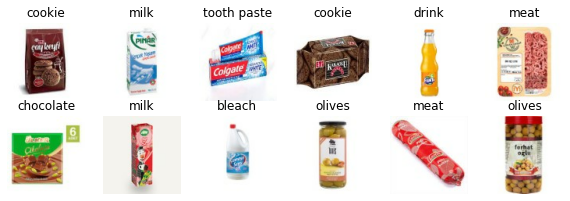

In [10]:
plt.figure(figsize=(10, 10))
class_names = val_ds.class_names
for images, labels in val_ds.take(1):
    for i in range(12):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [60]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(hp.Int("input_units", min_value=32, max_value=256, step=32), 3, input_shape = (100,100,3), activation = "relu"))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    for i in range(hp.Int("n_layers", 1,4)):
        model.add(layers.Conv2D(hp.Int(f"conv_{i}_units", 32, 256, 32), 3, activation='relu'))
        model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(layers.Flatten())
    
    for i in range(hp.Int("n2_layers", 1,4)):
        model.add(layers.Dense(hp.Int(f"conv_{i}_units", 32, 256, 32), activation='relu'))
    
    model.add(layers.Dense(9, activation="softmax"))
    
    model.compile(optimizer='adam',
            loss=tf.keras.losses.sparse_categorical_crossentropy,
                metrics=['accuracy'])
    
    return model

In [61]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial = 1,
    directory="logs/",
    project_name = 'intro_to_keras'
)

In [62]:
tuner.search(train_ds, epochs=5, batch_size=32, validation_data=val_ds)

Epoch 1/5
4/4 [==============================] - ETA: 2s - loss: 10.2018 - accuracy: 0.150 - ETA: 0s - loss: 13.8305 - accuracy: 0.109 - 1s 84ms/step - loss: 13.7930 - accuracy: 0.1050 - val_loss: 7.1324 - val_accuracy: 0.0500
Epoch 2/5
4/4 [==============================] - ETA: 0s - loss: 5.8163 - accuracy: 0.08 - 0s 41ms/step - loss: 5.7339 - accuracy: 0.0800 - val_loss: 3.4445 - val_accuracy: 0.1500
Epoch 3/5
4/4 [==============================] - ETA: 0s - loss: 3.5789 - accuracy: 0.10 - ETA: 0s - loss: 2.9635 - accuracy: 0.13 - 0s 40ms/step - loss: 2.8962 - accuracy: 0.1383 - val_loss: 2.5322 - val_accuracy: 0.1500
Epoch 4/5
4/4 [==============================] - ETA: 0s - loss: 2.3048 - accuracy: 0.10 - ETA: 0s - loss: 2.4086 - accuracy: 0.10 - 0s 40ms/step - loss: 2.4126 - accuracy: 0.1100 - val_loss: 2.8989 - val_accuracy: 0.1500
Epoch 5/5
4/4 [==============================] - ETA: 0s - loss: 2.6032 - accuracy: 0.20 - ETA: 0s - loss: 2.5597 - accuracy: 0.17 - 0s 41ms/step - l

Epoch 1/5
4/4 [==============================] - ETA: 3s - loss: 6.5179 - accuracy: 0.20 - ETA: 0s - loss: 37.4877 - accuracy: 0.141 - 1s 105ms/step - loss: 40.6886 - accuracy: 0.1250 - val_loss: 6.5021 - val_accuracy: 0.0500
Epoch 2/5
4/4 [==============================] - 0s 62ms/step - loss: 7.1115 - accuracy: 0.0967 - val_loss: 4.0902 - val_accuracy: 0.0500
Epoch 3/5
4/4 [==============================] - ETA: 0s - loss: 3.5984 - accuracy: 0.15 - ETA: 0s - loss: 3.5245 - accuracy: 0.11 - 0s 62ms/step - loss: 3.3601 - accuracy: 0.1050 - val_loss: 2.6013 - val_accuracy: 0.1500
Epoch 4/5
4/4 [==============================] - ETA: 0s - loss: 2.8141 - accuracy: 0.0000e+ - ETA: 0s - loss: 2.5612 - accuracy: 0.0500   - 0s 62ms/step - loss: 2.4335 - accuracy: 0.0750 - val_loss: 2.3604 - val_accuracy: 0.1500
Epoch 5/5
4/4 [==============================] - ETA: 0s - loss: 2.3073 - accuracy: 0.15 - ETA: 0s - loss: 2.2190 - accuracy: 0.22 - 0s 62ms/step - loss: 2.2055 - accuracy: 0.2250 - va

Epoch 1/5
4/4 [==============================] - ETA: 2s - loss: 4.8740 - accuracy: 0.0000e+ - ETA: 0s - loss: 13.6590 - accuracy: 0.0278   - 1s 92ms/step - loss: 14.0458 - accuracy: 0.0467 - val_loss: 2.5076 - val_accuracy: 0.0500
Epoch 2/5
4/4 [==============================] - 0s 45ms/step - loss: 2.3495 - accuracy: 0.1183 - val_loss: 2.3172 - val_accuracy: 0.1500
Epoch 3/5
4/4 [==============================] - ETA: 0s - loss: 2.3627 - accuracy: 0.05 - ETA: 0s - loss: 2.3970 - accuracy: 0.05 - 0s 46ms/step - loss: 2.3805 - accuracy: 0.0600 - val_loss: 2.2242 - val_accuracy: 0.1000
Epoch 4/5
4/4 [==============================] - ETA: 0s - loss: 2.0740 - accuracy: 0.20 - ETA: 0s - loss: 2.1011 - accuracy: 0.21 - 0s 45ms/step - loss: 2.1461 - accuracy: 0.1900 - val_loss: 2.1858 - val_accuracy: 0.1500
Epoch 5/5
4/4 [==============================] - ETA: 0s - loss: 2.3072 - accuracy: 0.05 - ETA: 0s - loss: 2.2640 - accuracy: 0.08 - 0s 45ms/step - loss: 2.2468 - accuracy: 0.0983 - val_

Epoch 1/5
4/4 [==============================] - ETA: 1s - loss: 25.8931 - accuracy: 0.050 - ETA: 0s - loss: 156.4068 - accuracy: 0.08 - 1s 79ms/step - loss: 156.8865 - accuracy: 0.0900 - val_loss: 25.0182 - val_accuracy: 0.1000
Epoch 2/5
4/4 [==============================] - ETA: 0s - loss: 15.9812 - accuracy: 0.074 - 0s 37ms/step - loss: 15.1234 - accuracy: 0.0817 - val_loss: 7.2421 - val_accuracy: 0.1000
Epoch 3/5
4/4 [==============================] - ETA: 0s - loss: 6.4963 - accuracy: 0.15 - ETA: 0s - loss: 5.5153 - accuracy: 0.11 - 0s 37ms/step - loss: 5.3225 - accuracy: 0.1100 - val_loss: 2.4212 - val_accuracy: 0.1500
Epoch 4/5
4/4 [==============================] - ETA: 0s - loss: 2.0587 - accuracy: 0.20 - ETA: 0s - loss: 2.0399 - accuracy: 0.22 - 0s 38ms/step - loss: 2.0529 - accuracy: 0.2133 - val_loss: 2.2618 - val_accuracy: 0.2500
Epoch 5/5
4/4 [==============================] - ETA: 0s - loss: 1.8545 - accuracy: 0.30 - ETA: 0s - loss: 1.8895 - accuracy: 0.29 - 0s 38ms/ste

Epoch 1/5
4/4 [==============================] - ETA: 1s - loss: 21.7787 - accuracy: 0.050 - ETA: 0s - loss: 186.6288 - accuracy: 0.05 - 1s 76ms/step - loss: 194.8243 - accuracy: 0.0650 - val_loss: 47.9700 - val_accuracy: 0.1000
Epoch 2/5
4/4 [==============================] - 0s 31ms/step - loss: 43.7239 - accuracy: 0.0767 - val_loss: 4.0779 - val_accuracy: 0.2500
Epoch 3/5
4/4 [==============================] - ETA: 0s - loss: 3.7445 - accuracy: 0.15 - 0s 30ms/step - loss: 2.9599 - accuracy: 0.1367 - val_loss: 2.1900 - val_accuracy: 0.2500
Epoch 4/5
4/4 [==============================] - ETA: 0s - loss: 2.0046 - accuracy: 0.25 - 0s 29ms/step - loss: 2.0528 - accuracy: 0.2350 - val_loss: 2.1269 - val_accuracy: 0.1500
Epoch 5/5
4/4 [==============================] - ETA: 0s - loss: 1.7826 - accuracy: 0.40 - 0s 29ms/step - loss: 1.7642 - accuracy: 0.4183 - val_loss: 2.1988 - val_accuracy: 0.1500


Epoch 1/5
4/4 [==============================] - ETA: 2s - loss: 10.3546 - accuracy: 0.200 - ETA: 0s - loss: 67.1980 - accuracy: 0.147 - 1s 87ms/step - loss: 76.6503 - accuracy: 0.1433 - val_loss: 23.2575 - val_accuracy: 0.0500
Epoch 2/5
4/4 [==============================] - 0s 48ms/step - loss: 12.3879 - accuracy: 0.1400 - val_loss: 4.8681 - val_accuracy: 0.1000
Epoch 3/5
4/4 [==============================] - ETA: 0s - loss: 3.0944 - accuracy: 0.25 - ETA: 0s - loss: 3.2088 - accuracy: 0.19 - 0s 48ms/step - loss: 3.1459 - accuracy: 0.1767 - val_loss: 2.2880 - val_accuracy: 0.1000
Epoch 4/5
4/4 [==============================] - ETA: 0s - loss: 2.2190 - accuracy: 0.20 - ETA: 0s - loss: 2.2066 - accuracy: 0.20 - 0s 48ms/step - loss: 2.1666 - accuracy: 0.2150 - val_loss: 2.0559 - val_accuracy: 0.2000
Epoch 5/5
4/4 [==============================] - ETA: 0s - loss: 1.7315 - accuracy: 0.30 - ETA: 0s - loss: 1.8325 - accuracy: 0.29 - 0s 48ms/step - loss: 1.8203 - accuracy: 0.3133 - val_los

Epoch 1/5
4/4 [==============================] - ETA: 2s - loss: 3.7350 - accuracy: 0.15 - ETA: 0s - loss: 9.2756 - accuracy: 0.15 - 1s 85ms/step - loss: 9.9405 - accuracy: 0.1500 - val_loss: 13.2281 - val_accuracy: 0.0500
Epoch 2/5
4/4 [==============================] - ETA: 0s - loss: 10.1456 - accuracy: 0.084 - 0s 40ms/step - loss: 9.6225 - accuracy: 0.0850 - val_loss: 2.7334 - val_accuracy: 0.1000
Epoch 3/5
4/4 [==============================] - ETA: 0s - loss: 2.6360 - accuracy: 0.10 - ETA: 0s - loss: 2.5129 - accuracy: 0.11 - 0s 40ms/step - loss: 2.5006 - accuracy: 0.1133 - val_loss: 2.4349 - val_accuracy: 0.1500
Epoch 4/5
4/4 [==============================] - ETA: 0s - loss: 2.1967 - accuracy: 0.20 - ETA: 0s - loss: 2.1969 - accuracy: 0.18 - 0s 39ms/step - loss: 2.1987 - accuracy: 0.1817 - val_loss: 2.1282 - val_accuracy: 0.2000
Epoch 5/5
4/4 [==============================] - ETA: 0s - loss: 2.0252 - accuracy: 0.25 - ETA: 0s - loss: 2.0903 - accuracy: 0.25 - 0s 39ms/step - los

Epoch 1/5
4/4 [==============================] - ETA: 1s - loss: 3.8570 - accuracy: 0.15 - ETA: 0s - loss: 11.0901 - accuracy: 0.143 - 1s 86ms/step - loss: 11.7432 - accuracy: 0.1400 - val_loss: 5.7200 - val_accuracy: 0.1500
Epoch 2/5
4/4 [==============================] - ETA: 0s - loss: 5.8766 - accuracy: 0.05 - 0s 38ms/step - loss: 5.5326 - accuracy: 0.0600 - val_loss: 2.2576 - val_accuracy: 0.1500
Epoch 3/5
4/4 [==============================] - ETA: 0s - loss: 2.2508 - accuracy: 0.10 - ETA: 0s - loss: 2.2438 - accuracy: 0.09 - 0s 38ms/step - loss: 2.2407 - accuracy: 0.0950 - val_loss: 2.2031 - val_accuracy: 0.1500
Epoch 4/5
4/4 [==============================] - ETA: 0s - loss: 2.1448 - accuracy: 0.20 - ETA: 0s - loss: 2.1437 - accuracy: 0.18 - 0s 38ms/step - loss: 2.1476 - accuracy: 0.1817 - val_loss: 2.3232 - val_accuracy: 0.0500
Epoch 5/5
4/4 [==============================] - ETA: 0s - loss: 2.0061 - accuracy: 0.15 - ETA: 0s - loss: 2.0652 - accuracy: 0.14 - 0s 38ms/step - los

Epoch 1/5
4/4 [==============================] - ETA: 1s - loss: 3.8824 - accuracy: 0.15 - ETA: 0s - loss: 4.7309 - accuracy: 0.19 - 1s 94ms/step - loss: 5.2826 - accuracy: 0.1900 - val_loss: 5.1374 - val_accuracy: 0.2000
Epoch 2/5
4/4 [==============================] - 0s 49ms/step - loss: 5.1871 - accuracy: 0.1450 - val_loss: 2.7213 - val_accuracy: 0.1000
Epoch 3/5
4/4 [==============================] - ETA: 0s - loss: 2.6574 - accuracy: 0.10 - ETA: 0s - loss: 2.4899 - accuracy: 0.11 - 0s 48ms/step - loss: 2.4300 - accuracy: 0.1133 - val_loss: 2.2495 - val_accuracy: 0.0500
Epoch 4/5
4/4 [==============================] - ETA: 0s - loss: 2.2269 - accuracy: 0.25 - ETA: 0s - loss: 2.1792 - accuracy: 0.22 - 0s 47ms/step - loss: 2.1762 - accuracy: 0.2200 - val_loss: 2.1697 - val_accuracy: 0.1500
Epoch 5/5
4/4 [==============================] - ETA: 0s - loss: 2.0728 - accuracy: 0.10 - ETA: 0s - loss: 2.0356 - accuracy: 0.14 - 0s 47ms/step - loss: 2.0410 - accuracy: 0.1583 - val_loss: 2.07

Epoch 1/5
4/4 [==============================] - ETA: 3s - loss: 2.2035 - accuracy: 0.25 - ETA: 0s - loss: 5.5155 - accuracy: 0.20 - 1s 101ms/step - loss: 5.5607 - accuracy: 0.1700 - val_loss: 2.4221 - val_accuracy: 0.2000
Epoch 2/5
4/4 [==============================] - 0s 55ms/step - loss: 2.4393 - accuracy: 0.1283 - val_loss: 2.3661 - val_accuracy: 0.1000
Epoch 3/5
4/4 [==============================] - ETA: 0s - loss: 2.2030 - accuracy: 0.10 - ETA: 0s - loss: 2.2071 - accuracy: 0.13 - 0s 55ms/step - loss: 2.2168 - accuracy: 0.1400 - val_loss: 2.2529 - val_accuracy: 0.1500
Epoch 4/5
4/4 [==============================] - ETA: 0s - loss: 2.2006 - accuracy: 0.20 - ETA: 0s - loss: 2.1868 - accuracy: 0.18 - 0s 55ms/step - loss: 2.1873 - accuracy: 0.1783 - val_loss: 2.2273 - val_accuracy: 0.1000
Epoch 5/5
4/4 [==============================] - ETA: 0s - loss: 2.1927 - accuracy: 0.10 - ETA: 0s - loss: 2.1806 - accuracy: 0.09 - 0s 55ms/step - loss: 2.1785 - accuracy: 0.1133 - val_loss: 2.2

INFO:tensorflow:Oracle triggered exit


In [36]:
best_hps = tuner.get_best_hyperparameters

In [38]:
tuner.results_summary()

In [55]:
best_hp = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hp)

In [56]:
epochs = 15
history = model.fit(train_ds, epochs=epochs, batch_size=20, validation_data=val_ds)

Epoch 1/15
4/4 [==============================] - ETA: 1s - loss: 66.0627 - accuracy: 0.150 - 1s 61ms/step - loss: 510.8746 - accuracy: 0.1567 - val_loss: 645.5382 - val_accuracy: 0.1500
Epoch 2/15
4/4 [==============================] - ETA: 0s - loss: 719.3611 - accuracy: 0.15 - 0s 25ms/step - loss: 469.7319 - accuracy: 0.1983 - val_loss: 56.0911 - val_accuracy: 0.1000
Epoch 3/15
4/4 [==============================] - ETA: 0s - loss: 46.1084 - accuracy: 0.250 - 0s 24ms/step - loss: 26.7378 - accuracy: 0.3867 - val_loss: 11.7709 - val_accuracy: 0.3000
Epoch 4/15
4/4 [==============================] - ETA: 0s - loss: 2.6928 - accuracy: 0.35 - 0s 25ms/step - loss: 2.3355 - accuracy: 0.4917 - val_loss: 6.9846 - val_accuracy: 0.2000
Epoch 5/15
4/4 [==============================] - ETA: 0s - loss: 0.7778 - accuracy: 0.70 - 0s 25ms/step - loss: 0.5873 - accuracy: 0.8100 - val_loss: 4.7659 - val_accuracy: 0.3000
Epoch 6/15
4/4 [==============================] - ETA: 0s - loss: 0.1492 - accur

In [51]:
def reset_seeds():
    np.random.seed(1)
    random.seed(2)
    if tf.__version__[0] == '2':
        tf.random.set_seed(3)
    else:
        tf.set_random_seed(3)
    print("RANDOM SEEDS RESET")

In [52]:
reset_seeds()
del history
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()

RANDOM SEEDS RESET


In [59]:
evaluation = model.evaluate(val_ds, batch_size=32, verbose=1) 
evaluation

1/1 [==============================] - ETA: 0s - loss: 6.1296 - accuracy: 0.55 - 0s 30ms/step - loss: 6.1296 - accuracy: 0.5500


[6.129645347595215, 0.550000011920929]

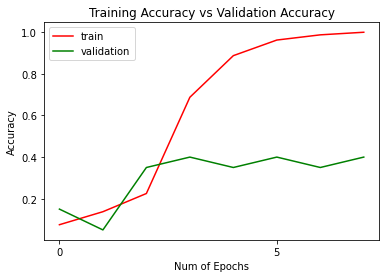

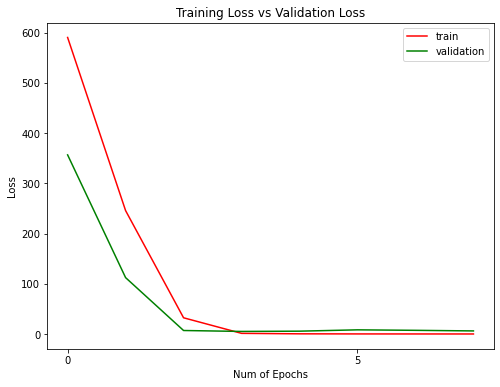

In [49]:
plt.figure(0) 
plt.plot(history.history['accuracy'],'r') 
plt.plot(history.history['val_accuracy'],'g') 
plt.xticks(np.arange(0, epochs, 5.0)) 
plt.rcParams['figure.figsize'] = (8, 6) 
plt.xlabel("Num of Epochs") 
plt.ylabel("Accuracy") 
plt.title("Training Accuracy vs Validation Accuracy") 
plt.legend(['train','validation']) 

plt.figure(1) 
plt.plot(history.history['loss'],'r') 
plt.plot(history.history['val_loss'],'g') 
plt.xticks(np.arange(0, epochs, 5.0)) 
plt.rcParams['figure.figsize'] = (8, 6) 
plt.xlabel("Num of Epochs") 
plt.ylabel("Loss") 
plt.title("Training Loss vs Validation Loss") 
plt.legend(['train','validation']) 

plt.show()